In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,CSVLogger,TensorBoard
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
import seaborn as sns

In [3]:
dataset = pd.read_csv("Datasets/Balanced binary datasets/Pletor_balanced_ransomware.csv")
dataset = dataset. iloc[:, 1:]
print("Original dataset size: ",dataset.shape)

print(f"Number of unique values in the 'Label' column: {dataset['Label'].nunique()}")
print(dataset.head())

Original dataset size:  (43260, 21)
Number of unique values in the 'Label' column: 2
   Flow IAT Min  Flow IAT Max  Flow Duration  Flow Packets/s  Flow IAT Mean  \
0            10       1067261        1487694       28.903793   3.542129e+04   
1          9160          9160           9160      218.340611   9.160000e+03   
2            49      24997045       29472537        0.950037   1.091575e+06   
3            47      29963123       30219225        0.496373   2.158516e+06   
4          2219          2219           2219      901.306895   2.219000e+03   

   Init_Win_bytes_forward  Bwd Packets/s  Fwd IAT Min  Fwd IAT Total  \
0                   65535      14.787987           10        1487694   
1                     118     109.170306            0              0   
2                   65535       0.441089          792        4475428   
3                   65535       0.264732          145         256048   
4                    1025     450.653448            0              0   

   Fwd 

In [4]:
def handle_dups_n_nans(dataSet):
    dataSet = dataSet.drop_duplicates()
    dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataSet.dropna(inplace=True)

    return dataSet

def normalise_features(dataSet):
    numerical_features = dataSet.select_dtypes(include=['float64', 'int64']).columns

    mean = dataSet[numerical_features].mean()
    std = dataSet[numerical_features].std()

    dataSet[numerical_features] = (dataSet[numerical_features] - mean) / std

    return dataSet

def encode_categorical(dataSet):
    categorical_columns = dataSet.select_dtypes(exclude=['float64', 'int64']).columns

    for column in categorical_columns:
        unique_categories = dataSet[column].unique()
        category_to_label = {category: label for label, category in enumerate(unique_categories)}
        dataSet[column] = dataSet[column].map(category_to_label)

    return dataSet

def perform_preprocessing(dataSet):
    temp = normalise_features(dataSet)
    temp = encode_categorical(temp)
    return temp

def split_Xy(df):
    X = df.drop('Label', axis=1)
    y = df['Label']
    return X, y

# dataset = perform_preprocessing(dataset)
# dataset.head()

In [5]:
train_ratio = 0.8
n_samples = dataset.shape[0]
indices = np.random.permutation(n_samples)

train_size = int(train_ratio * n_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = dataset.iloc[train_indices]
test_data = dataset.iloc[test_indices]

train_data = handle_dups_n_nans(train_data)
test_data = handle_dups_n_nans(test_data)

X_train, y_train = split_Xy(train_data)
X_test, y_test = split_Xy(test_data)

X_train = perform_preprocessing(X_train)
X_test = perform_preprocessing(X_test)

print("Train shape: ",X_train.shape," ",y_train.shape)
print("Test shape: ",X_test.shape," ",y_test.shape)

print(X_train.head())
print(y_train.head())


Train shape:  (34181, 20)   (34181,)
Test shape:  (8606, 20)   (8606,)
       Flow IAT Min  Flow IAT Max  Flow Duration  Flow Packets/s  \
25881      0.073163     -0.390540      -0.395576       -0.126634   
42249     -0.232216     -0.502814      -0.487106       -0.115457   
23852      1.360016      0.092762       0.000642       -0.126653   
8831      -0.232171     -0.503768      -0.488357       -0.123063   
14442     -0.232211      0.127199       0.213602       -0.126640   

       Flow IAT Mean  Init_Win_bytes_forward  Bwd Packets/s  Fwd IAT Min  \
25881      -0.090661               -0.696428      -0.102295     0.066145   
42249      -0.366821               -0.745882      -0.084168    -0.226406   
23852       1.074353               -0.704067      -0.102295     1.298942   
8831       -0.365908               -0.687550      -0.102295    -0.226363   
14442      -0.160362                1.389384      -0.102260    -0.226377   

       Fwd IAT Total  Fwd IAT Max  Fwd IAT Mean  Flow Bytes/s  

C:\Users\archi\AppData\Local\Temp\ipykernel_18452\1967025077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\archi\AppData\Local\Temp\ipykernel_18452\1967025077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.dropna(inplace=True)


In [17]:
# lets make our NN model layers
np.random.seed(42)
tf.random.set_seed(42)
num_features = 20
num_classes = 1
noOfEpochs=200
learningRate = 0.0005

model = Sequential([
    Dense(32, activation='leaky_relu', input_shape=(num_features,),kernel_initializer=HeNormal(), kernel_regularizer=l2(0.03)),  # Input Layer
    Dense(32, activation='leaky_relu', kernel_regularizer=l2(0.03), kernel_initializer=HeNormal()),
    Dense(num_classes, activation='sigmoid')  # Output Layer
])

optimizer = Adam(learning_rate=learningRate)

model.compile(
    optimizer=optimizer,  # Adaptive Moment Estimation optimizer
    loss='binary_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Tracking accuracy during training
)

model.summary()

C:\Users\archi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                     │ (None, 32)                  │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761 (6.88 KB)

 Trainable params: 1,761 (6.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
checkpoint = ModelCheckpoint(
    filepath='model_checkpoint.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)
tensorboard = TensorBoard(log_dir="logs", histogram_freq=1)
csv_logger = CSVLogger('training_log.csv', append=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=noOfEpochs,  # Number of training epochs
    batch_size=32,  # Mini-batch size
    verbose=1,  # Display training progress
    callbacks=[reduce_lr,checkpoint, csv_logger, tensorboard]
)

Epoch 1/200
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5121 - loss: 3.0604
Epoch 1: loss improved from inf to 2.07314, saving model to model_checkpoint.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5121 - loss: 3.0595 - val_accuracy: 0.5041 - val_loss: 0.9260 - learning_rate: 5.0000e-04
Epoch 2/200
1063/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5185 - loss: 0.8184
Epoch 2: loss improved from 2.07314 to 0.75932, saving model to model_checkpoint.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5185 - loss: 0.8180 - val_accuracy: 0.5019 - val_loss: 0.6992 - learning_rate: 5.0000e-04
Epoch 3/200
1067/1069 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5052 - loss: 0.6961
Epoch 3: loss improved from 0.75932 to 0.69462, saving model to model_checkpoint.keras
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5052 - loss: 0.6961 - val_accuracy: 0.5000 - val_loss: 0.6934 - learning_rate: 5.0000e-04
Epoch 4/200
1059/1069 ━━━━━━━━━━━━━

In [9]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

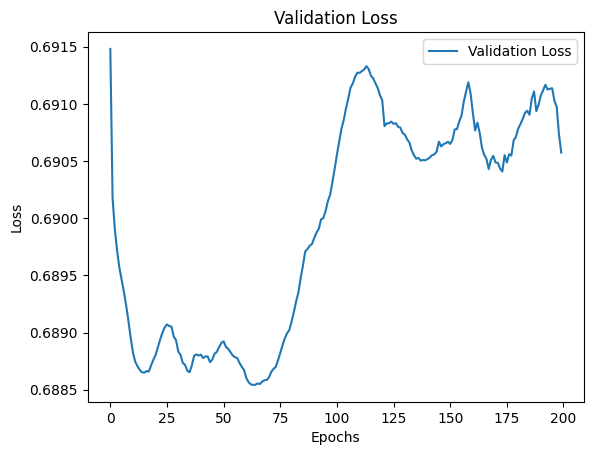

In [79]:
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

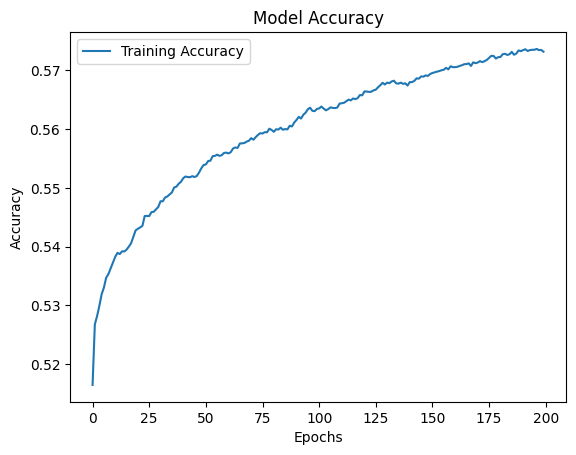

In [80]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

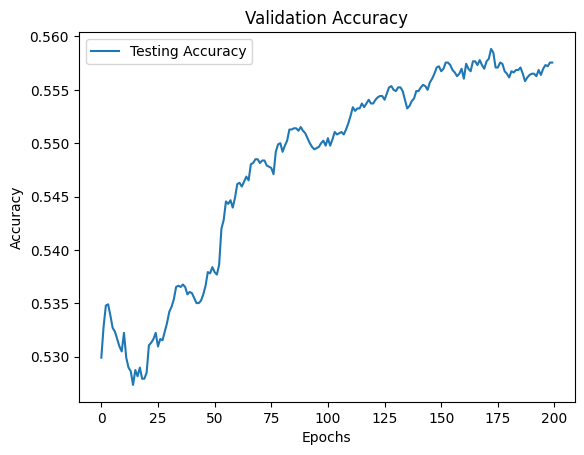

In [81]:
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()